# Stratification in deep ocean
Using best current case of tides and surface flux tuning:
* QCORRECT in summer everywhere, QCORRECT in winter north of 55 S
* QSOF Tf restriction
* SCORRECT all year with TNUDGE 30 days
* SSOF Tf salt input restriction
* tidal mask on shelf smooth transition
## Annual mean salt and temperature longitiude transsects compared against SOSE

In [10]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
fig_dir = os.path.join(proj_dir,'reports','devel','figures')
data_dir = os.path.join(proj_dir,'data')
src_path = os.path.join(os.environ.get('projdir'),'src')

sys.path.append(src_path)
# import my functions
import tools.make_roms_ds as roms_ds

import tools.make_sose_ds as sose_ds

In [2]:
# %load ../../src/tools/make_roms_ds.py
#read in raw data as xr.dataset
import xarray as xr
import numpy as np
from tools.calc_z import calc_z
from tools.cartesian_grid_3d import cartesian_grid_3d
from tools.rotate_vector_roms import rotate_vector_roms
import gsw


def make_3D_XiEta(ds,grd):
    
    xi_3d = np.tile(grd.xi_rho,(31,grd.eta_rho.size,1))
    eta_3d = np.swapaxes(np.tile(grd.eta_rho,(31,grd.xi_rho.size,1)),1,2)
    
    xi_3d = xr.DataArray(xi_3d,dims=['s_rho','eta_rho','xi_rho'])
    eta_3d = xr.DataArray(eta_3d,dims=['s_rho','eta_rho','xi_rho'])
    
    #ds = ds.assign_coords(xi_3d=xi_3d_da)
    #ds = ds.assign_coords(eta_3d=eta_3d_da)
    
    #ds.xi_3d.attrs = grd.xi_rho.attrs
    #ds.eta_3d.attrs = grd.eta_rho.attrs
    
    return xi_3d,eta_3d



def make_3D_depth(ds,grd,zeta):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    Vstretching = 4    
    zeta = zeta.values
        
    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    depth_3d =    xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']) 
    #ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    return depth_3d

def make_4D_density(grd,ds):

    rho = np.empty((ds.ocean_time.size,31,grd.eta_rho.size,grd.xi_rho.size))

    for tstep in np.arange(ds.ocean_time.size):
        p = gsw.conversions.p_from_z(grd.depth.isel(ocean_time=tstep),grd.lat_rho)
        SA = gsw.conversions.SA_from_SP(grd.salt.isel(ocean_time=tstep),p,grd.lon_rho,grd.lat_rho)
        CT = gsw.conversions.CT_from_pt(SA,grd.temp.isel(ocean_time=tstep))
        rho[tstep]=gsw.density.rho(SA,CT,p)

    ds = grd.assign_coords(rho = xr.DataArray(rho,dims=['ocean_time','s_rho','eta_rho','xi_rho']))

    return ds

In [3]:
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
temp = xr.open_dataset(temp_path).temp.isel(ocean_time=0)
salt = xr.open_dataset(salt_path).salt.isel(ocean_time=0)
zeta = xr.open_dataset(zeta_path).zeta.isel(ocean_time=0)

grd_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

In [4]:
xi_3d,eta_3d = make_3D_XiEta(temp,grd)

In [5]:
depth_3d = make_3D_depth(temp,grd,zeta)

In [6]:
rds = grd.copy()
rds['temp'] = temp
rds['salt'] = salt
rds = rds.assign_coords(xi_3d=xi_3d)
rds = rds.assign_coords(eta_3d=eta_3d)
rds = rds.assign_coords(depth = depth_3d)

rds = rds.assign_coords(lat_rho = grd.lat_rho)
rds = rds.assign_coords(lon_rho = grd.lon_rho)

In [51]:
#load sose_data
sose_path = os.path.join(data_dir,'preprocessing','external','sose')
sds = sose_ds.make_TS_ds(sose_dir=sose_path,records=np.arange(0,12))
sds = sds.mean('time')

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


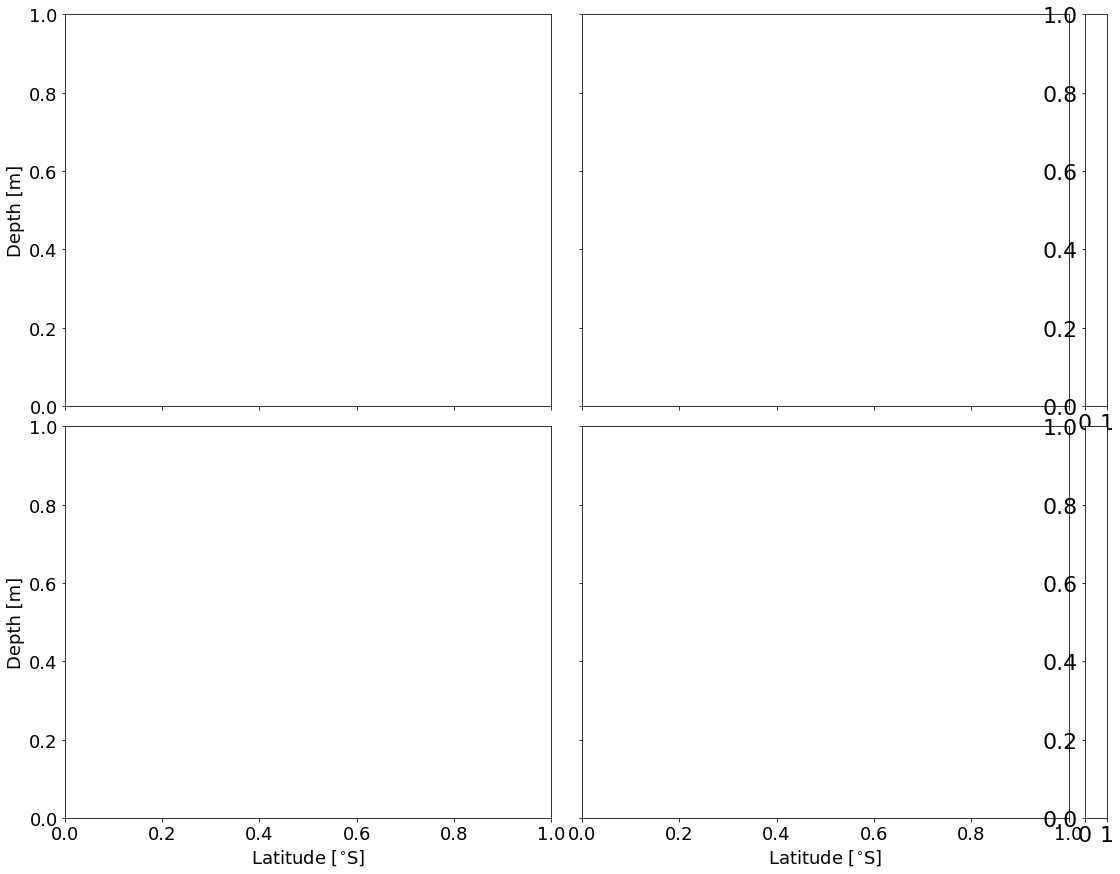

In [136]:
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid

plt.close()

matplotlib.rcParams.update({'font.size': 22})

fig,axes = plt.subplots(2,2,figsize=(15,12))


(ax1,ax2,ax3,ax4) = axes.flatten() 

for ax in axes.flatten()[0:2]:
    ax.set_xticklabels('')
    
for ax in axes.flatten()[[1,3]]:
    ax.set_yticklabels('')
    
for ax in axes.flatten()[2:]:
    ax.set_xlabel('Latitude [$^{\circ}$S]',fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
for ax in axes.flatten()[[0,2]]:
    ax.set_ylabel('Depth [m]',fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
fig.tight_layout(pad=0.1)
    
p0 = axes.flatten()[1].get_position().get_points().flatten()
ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])

p1 = axes.flatten()[3].get_position().get_points().flatten()
ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])


plt.show()

In [64]:
sds['depth'] = sds.depth*10**-3
rds['depth'] = rds.depth*10**-3

In [195]:
#%%writefile ../../src/visualization/compare_tracer.py
#define function that generates a sose vs roms longitude transsect as monthly widget or annual meandefine function that generates a sose vs roms longitude transsect as monthly widget or annual mean
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm
import matplotlib

def plot_lont(title,sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,save=False,size=100,sel=False):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    rds= rds.isel(sel)
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    print('lookup nearest neighbors from sose')
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    #lats_t = np.linspace(lats.min(),lats.max(),size)
    #lons_t = np.repeat(lon,size)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,ind]
    rsalt_tr = rsalt_flat[:,ind]
    x=rtemp_tr.lat_rho.fillna(0).values
    y=rtemp_tr.depth.fillna(0).values
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('plotting')
    plt.close()
        
    fig,axes = plt.subplots(2,2,figsize=(15,12))
    matplotlib.rcParams.update({'font.size': 24})
    plt.rcParams['axes.facecolor']='gray'
    #plt.rcParams['savefig.facecolor']='gray'

    (ax1,ax2,ax3,ax4) = axes.flatten()
    ocm.thermal.set_bad('gray')
    ocm.haline.set_bad('gray')

    
    sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax1,
                                    x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal,
                                    add_colorbar=False)
    
    
    sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax3,
                                    x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline,
                                    add_colorbar=False)

    ax2.set_facecolor('gray')
    temp_plt = ax2.pcolormesh(x,y,rtemp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax4.set_facecolor('gray')
    salt_plt = ax4.pcolormesh(x,y,rsalt_val,vmin=smin,vmax=smax,cmap=ocm.haline)  
    
    ax1.set_title('SOSE')
    ax2.set_title('ROMS')
    ax3.set_title('')
    
    for ax in axes.flatten()[[0,1]]:
        ax.set_xticklabels('')
        ax.set_xlabel('')
    
    for ax in axes.flatten()[[1,3]]:
        ax.set_yticklabels('')

    for ax in axes.flatten()[2:]:
        ax.set_xlabel('Latitude in $^{\circ}$S',fontsize=24)
        ax.tick_params(axis='x', labelsize=24)
    for ax in axes.flatten()[[0,2]]:
        #ax.ticklabel_format(axis="y",useOffset=-1000)
        ax.set_ylabel('Depth in km',fontsize=24)
        ax.tick_params(axis='y', labelsize=24)
        
    fig.tight_layout(pad=0.15)

    p0 = axes.flatten()[1].get_position().get_points().flatten()
    ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])
    cbar_upper = plt.colorbar(temp_plt, cax=ax_cbar_upper)
    cbar_upper.set_label('Temperature in $^{\circ}$C',weight = 'bold',size=24)
    cbar_upper.ax.tick_params(labelsize=24)

    p1 = axes.flatten()[3].get_position().get_points().flatten()
    ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])
    cbar_lower = plt.colorbar(salt_plt, cax=ax_cbar_lower)
    cbar_lower.set_label('Salinity in psu',weight = 'bold',size=24)
    cbar_lower.ax.tick_params(labelsize=24)
    
    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    if save:
        plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'ts_trans.png'),dpi=300,bbox_inches='tight')

    plt.show()

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


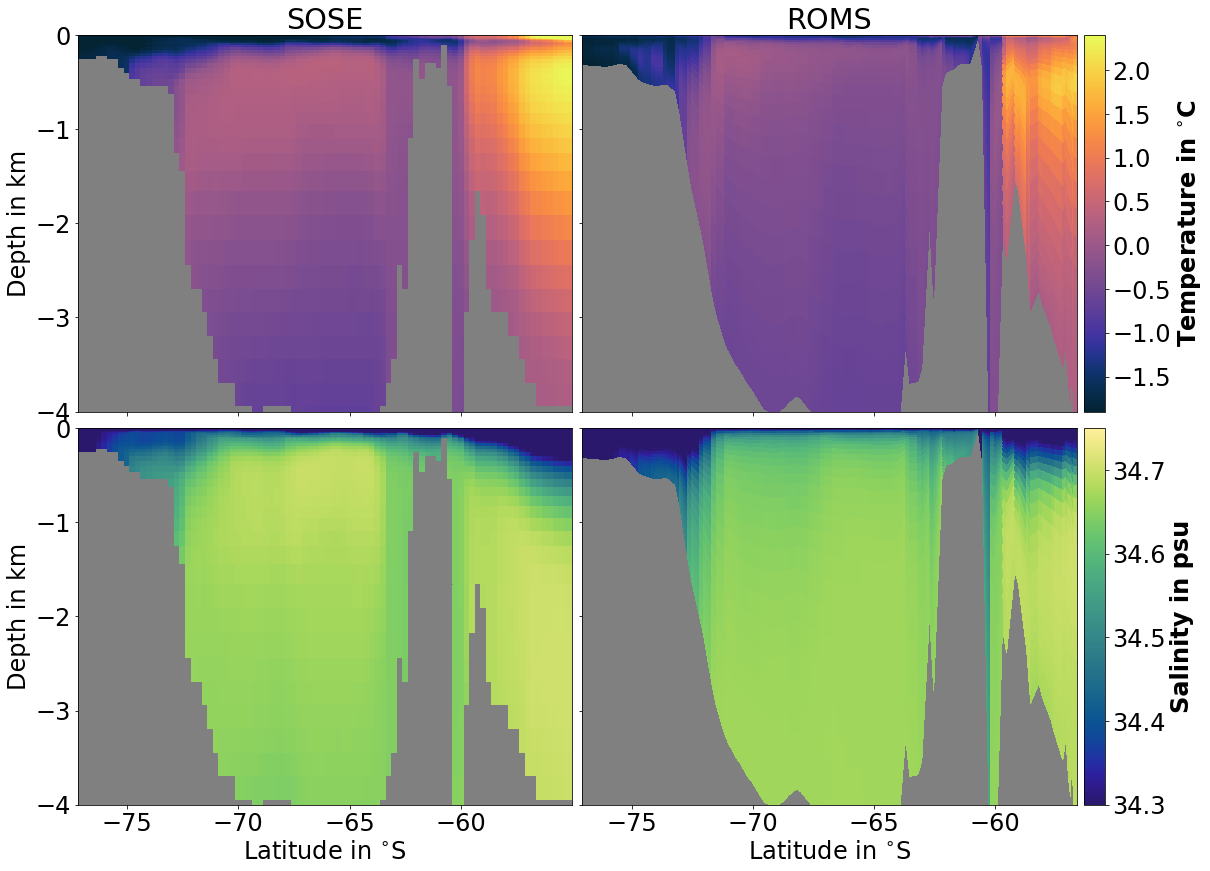

In [196]:
plot_lont('Weddell sea at longitude 45 deg W',sds,rds,-45,np.arange(-77,-55,0.25),tmin=-1.9,tmax=2.4,smin=34.3,smax=34.75,max_depth=4,
          save=True,sel={'xi_rho':slice(0,1200),'eta_rho':slice(1750,-1)})

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


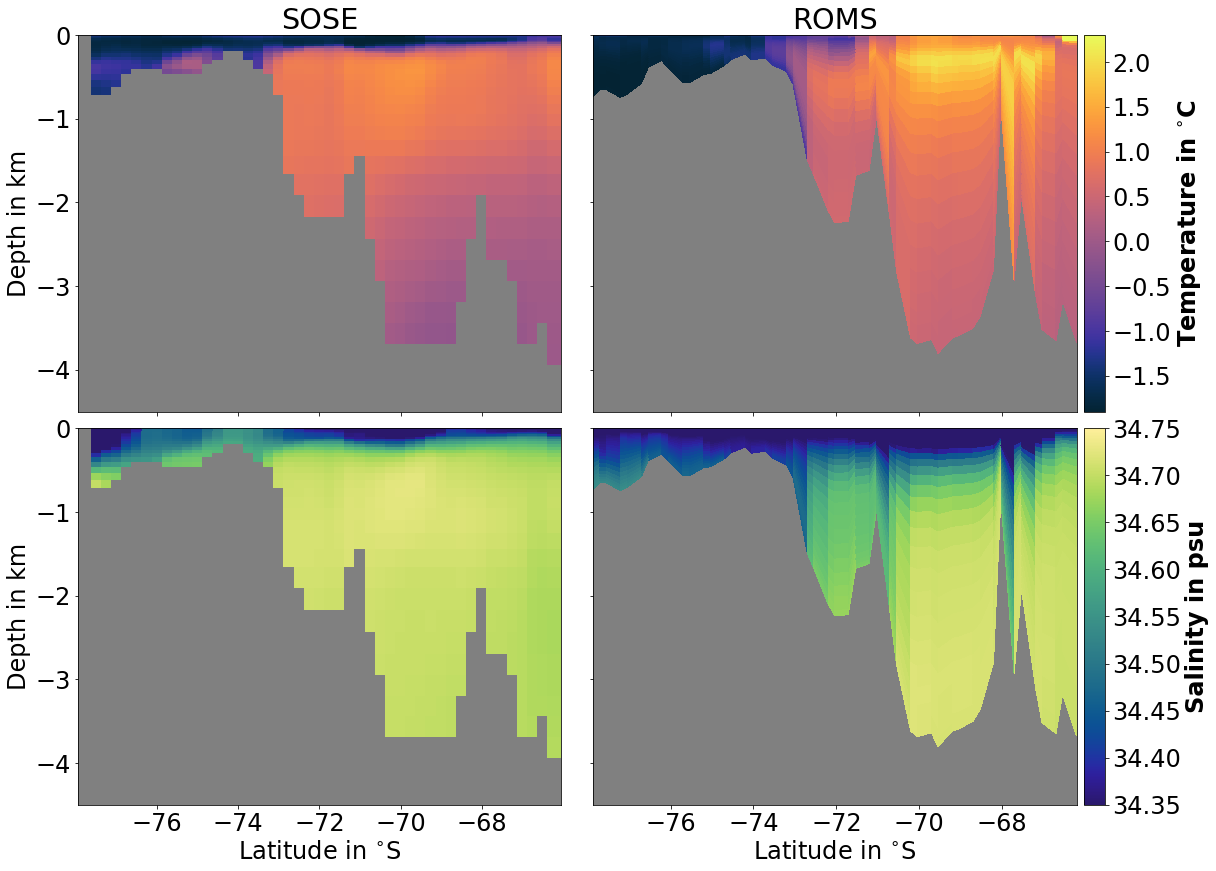

In [197]:
plot_lont('Ross sea at longitude 180',sds,rds,180,np.arange(-78,-66,0.25),tmin=-1.9,tmax=2.3,smin=34.35,smax=34.75,max_depth=4.5,
          save=True,sel={'eta_rho':slice(0,1000),'xi_rho':slice(1250,1750)})

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


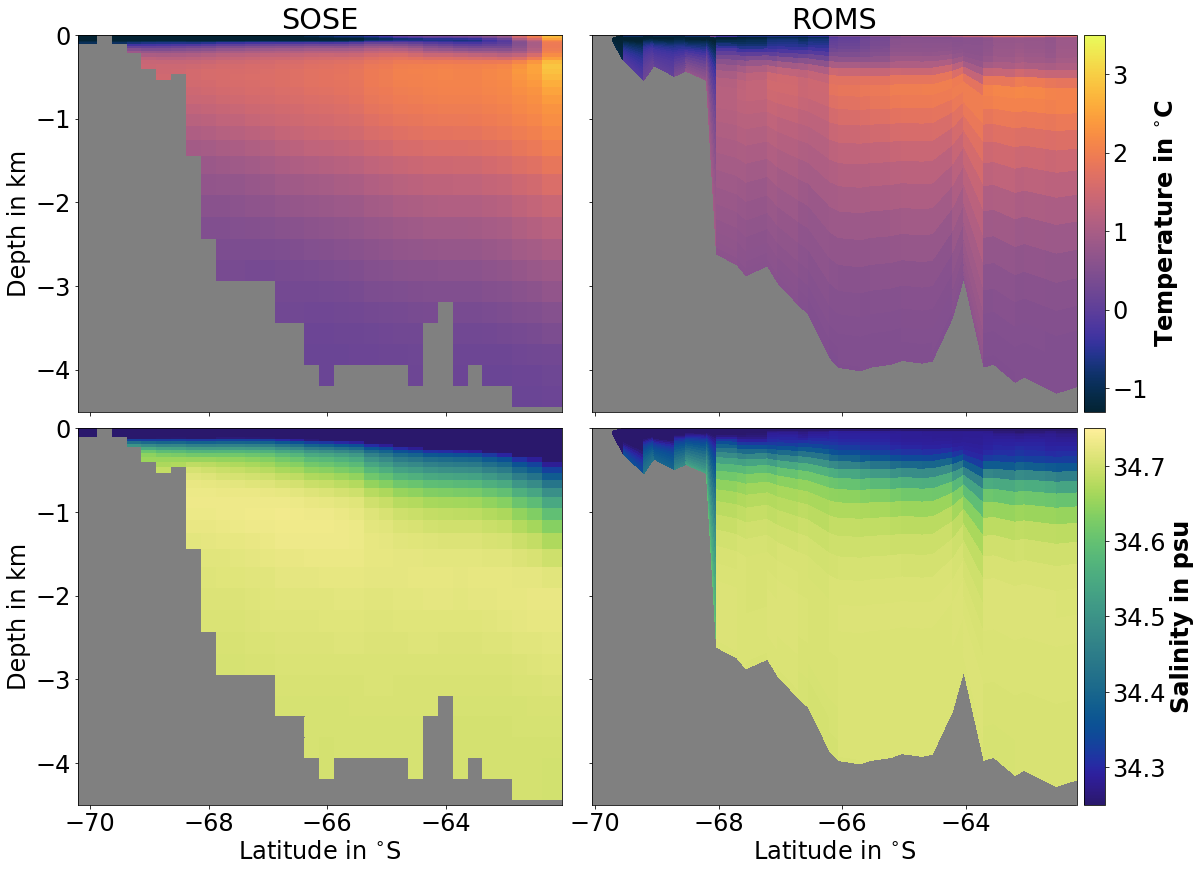

In [198]:
plot_lont('Bellinghausen Sea and Drake Passage at longitude 75 W',sds,rds,-75,np.arange(-70,-62,0.25),tmin=-1.3,tmax=3.5,smin=34.25,smax=34.75,max_depth=4.5,
          save=True,sel={'eta_rho':slice(1500,2000),'xi_rho':slice(0,500)})

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


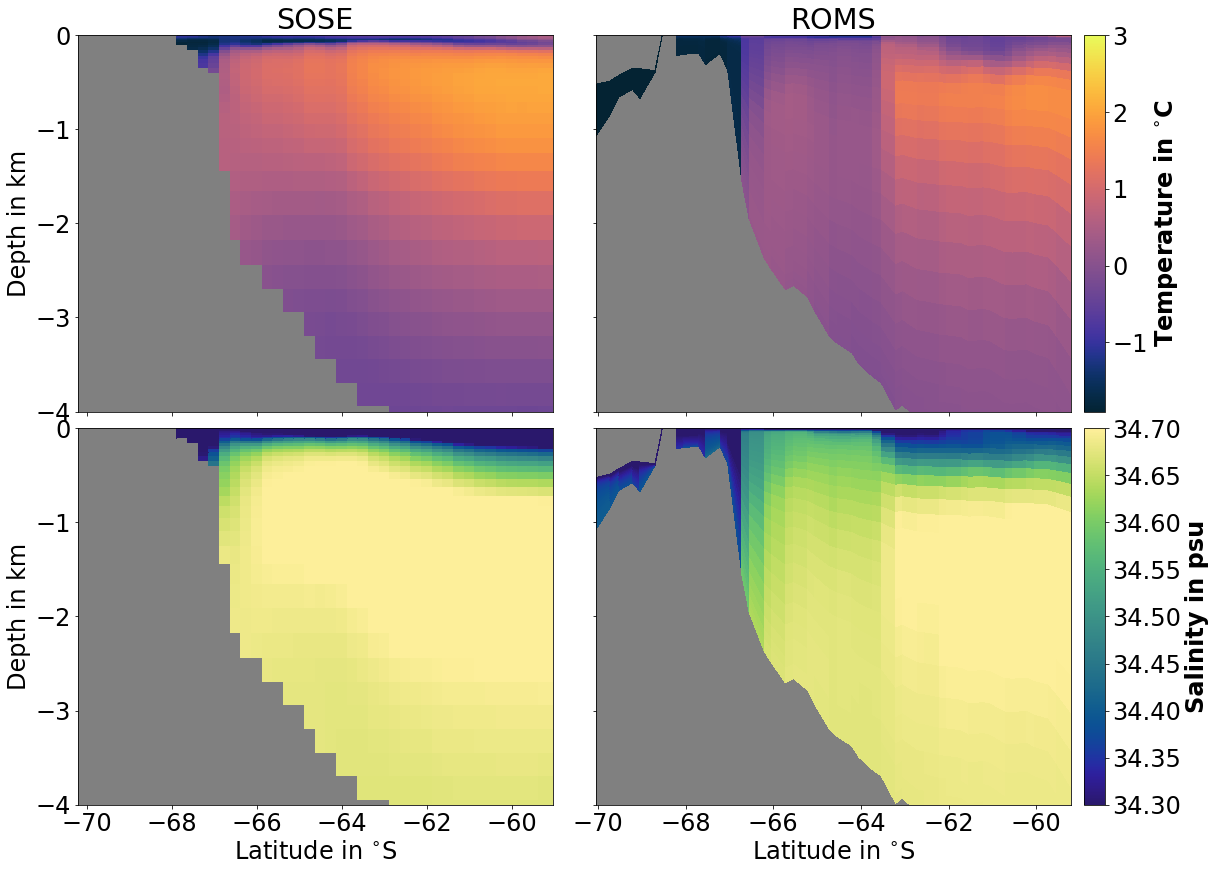

In [199]:
plot_lont('Davis sea longitude 70 deg E',sds,rds,70,np.arange(-70,-59,0.25),tmin=-1.9,tmax=3,smin=34.3,smax=34.7,max_depth=4,save=True,
         sel={'eta_rho':slice(1500,2500),'xi_rho':slice(2500,-1)})

## On shelf stratification
### Annual mean transsects along constant roms coordinates compared against SOSE

In [138]:
np.repeat(120,10).size

10

In [201]:
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm
import matplotlib

def plot_lont(title,rds,sds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,save=False,sel=False,size=10):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    if sel:
        rds = rds.isel(sel)
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    print('lookup nearest neighbors from sose')
    #lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    #lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    lats_t = np.linspace(lats.min(),lats.max(),size)
    lons_t = np.repeat(lon,size)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,ind]
    rsalt_tr = rsalt_flat[:,ind]
    x=rtemp_tr.lat_rho.fillna(0).values
    y=rtemp_tr.depth.fillna(0).values
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('plotting')
    plt.close()
        
    fig,axes = plt.subplots(2,figsize=(15,12))
    matplotlib.rcParams.update({'font.size': 24})
    plt.rcParams['axes.facecolor']='gray'
    #plt.rcParams['savefig.facecolor']='gray'

    (ax1,ax2) = axes.flatten()
    ocm.thermal.set_bad('gray')
    ocm.haline.set_bad('gray')

    ax1.set_facecolor('gray')
    temp_plt = ax1.pcolormesh(x,y,rtemp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax2.set_facecolor('gray')
    salt_plt = ax2.pcolormesh(x,y,rsalt_val,vmin=smin,vmax=smax,cmap=ocm.haline)  
    
    #ax1.set_title('SOSE')
    #ax2.set_title('ROMS')
    #ax3.set_title('')
    
    ax1.set_xticklabels('')
    ax1.set_xlabel('')
  
    ax2.set_xlabel('Latitude in $^{\circ}$S',fontsize=24)
    ax2.tick_params(axis='x', labelsize=24)
    
    for ax in axes.flatten()[:]:
        #ax.ticklabel_format(axis="y",useOffset=-1000)
        ax.set_ylabel('Depth in km',fontsize=24)
        ax.tick_params(axis='y', labelsize=24)
        
    fig.tight_layout()

    p0 = axes.flatten()[0].get_position().get_points().flatten()
    ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])
    cbar_upper = plt.colorbar(temp_plt, cax=ax_cbar_upper)
    cbar_upper.set_label('Temperature in $^{\circ}$C',weight = 'bold',size=24)
    cbar_upper.ax.tick_params(labelsize=24)

    p1 = axes.flatten()[1].get_position().get_points().flatten()
    ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])
    cbar_lower = plt.colorbar(salt_plt, cax=ax_cbar_lower)
    cbar_lower.set_label('Salinity in psu',weight = 'bold',size=24)
    cbar_lower.ax.tick_params(labelsize=24)
    
    if max_depth != None:
        for ax in [ax1,ax2]:
            ax.set_ylim([-max_depth,0])
    if save:
        plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'ts_trans.png'),dpi=300,bbox_inches='tight')

    plt.show()

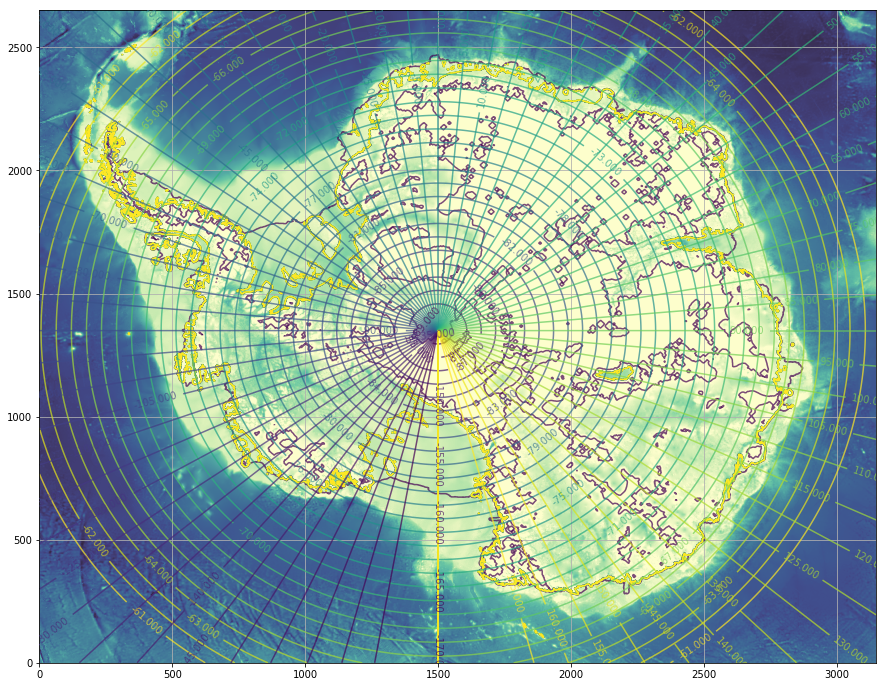

In [48]:
# defining the transsects and plot them over bathy and ice shelf front
plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=ocm.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
lat_plot = plt.contour(rds.lat_rho,levels=np.arange(-90,-60,1),alpha=0.7)
lon_plot =  plt.contour(rds.lon_rho,levels=np.arange(-170,170,5),alpha=0.7)

plt.clabel(lat_plot, inline=True)
plt.clabel(lon_plot, inline=True)

plt.grid()

#trans = [70,]

#for lon,lat_min,lat_max in trans:
#    mask = (grd.mask_rho == 1) & (grd.lat_rho>=lat_min) & (grd.lat_rho<=lat_max)
#    ax.contour(grd.lon_rho.where(mask),levels=[[lon]],colors=('white'),linewidths=1,
#          linestyles='dotted')

plt.show()

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


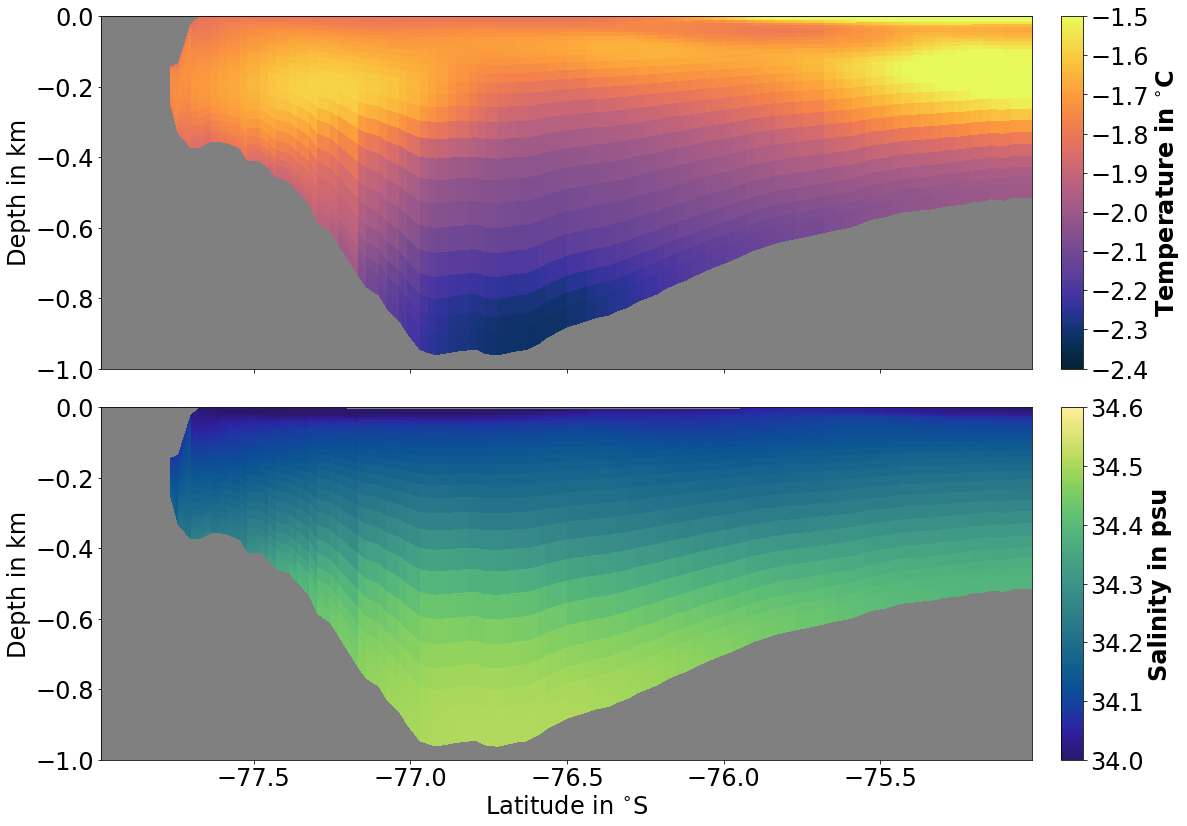

In [224]:
plot_lont('Weddell sea longitude 35 deg W',rds,sds,-35,np.arange(-78,-74),tmin=-2.4,tmax=-1.5,smin=34.0,smax=34.6,
          max_depth=1,size=100,
         sel={'eta_rho':slice(1750,2200),'xi_rho':slice(750,1200)},save=True)

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


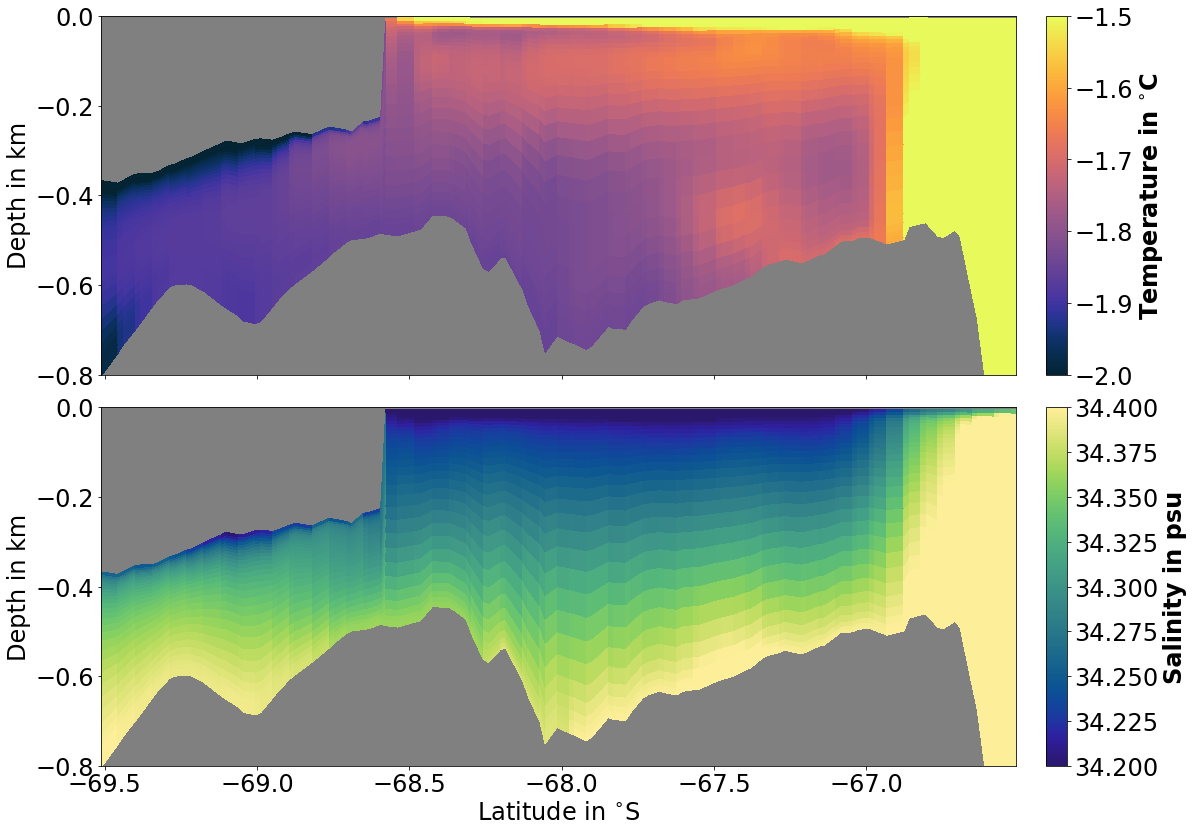

In [184]:
plot_lont('Davis sea longitude 72 deg E',rds,sds,72,np.arange(-69.5,-66),tmin=-2,tmax=-1.5,smin=34.2,smax=34.4,
          max_depth=0.8,size=100,
         sel={'eta_rho':slice(1500,2000),'xi_rho':slice(2250,2750)},save=True)

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


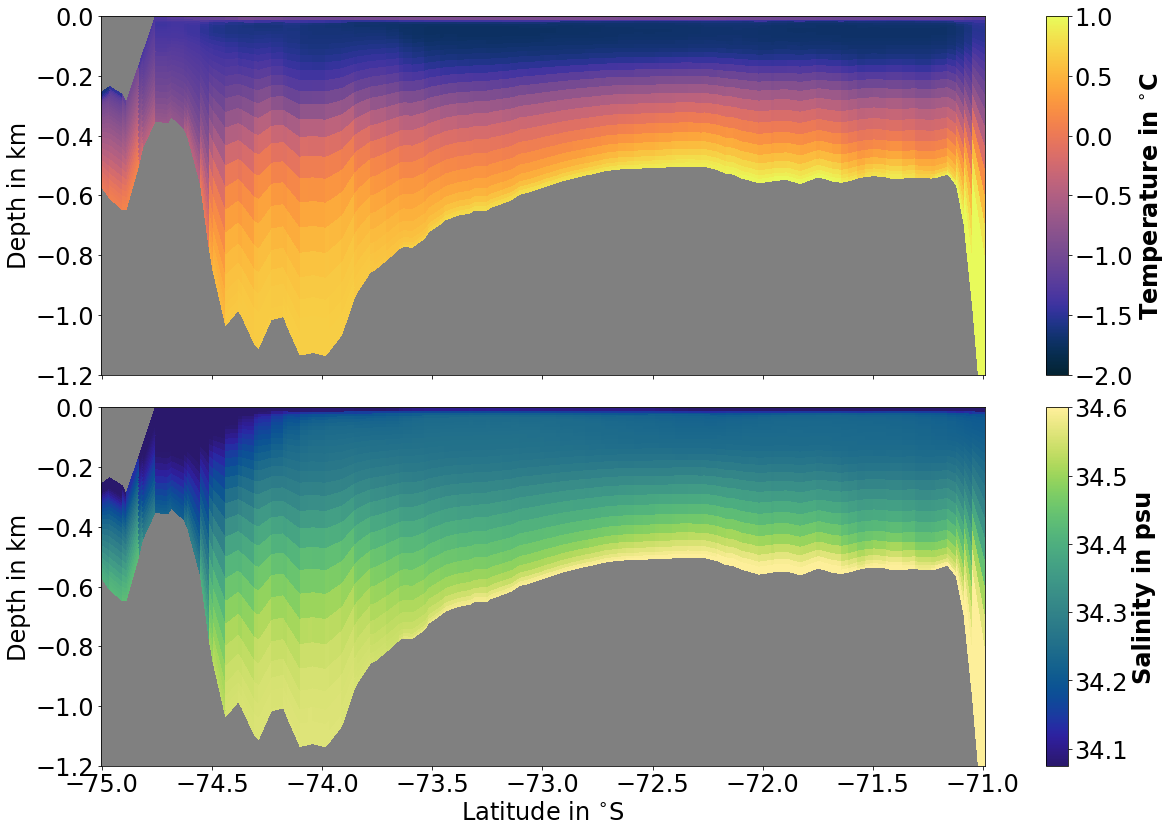

In [185]:
plot_lont('Amundsen sea longitude 106 deg W',rds,sds,-106,np.arange(-75,-70),tmin=-2,tmax=1,smin=34.075,smax=34.6,
          max_depth=1.2,size=100,
         sel={'eta_rho':slice(900,1300),'xi_rho':slice(300,900)},save=True)

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


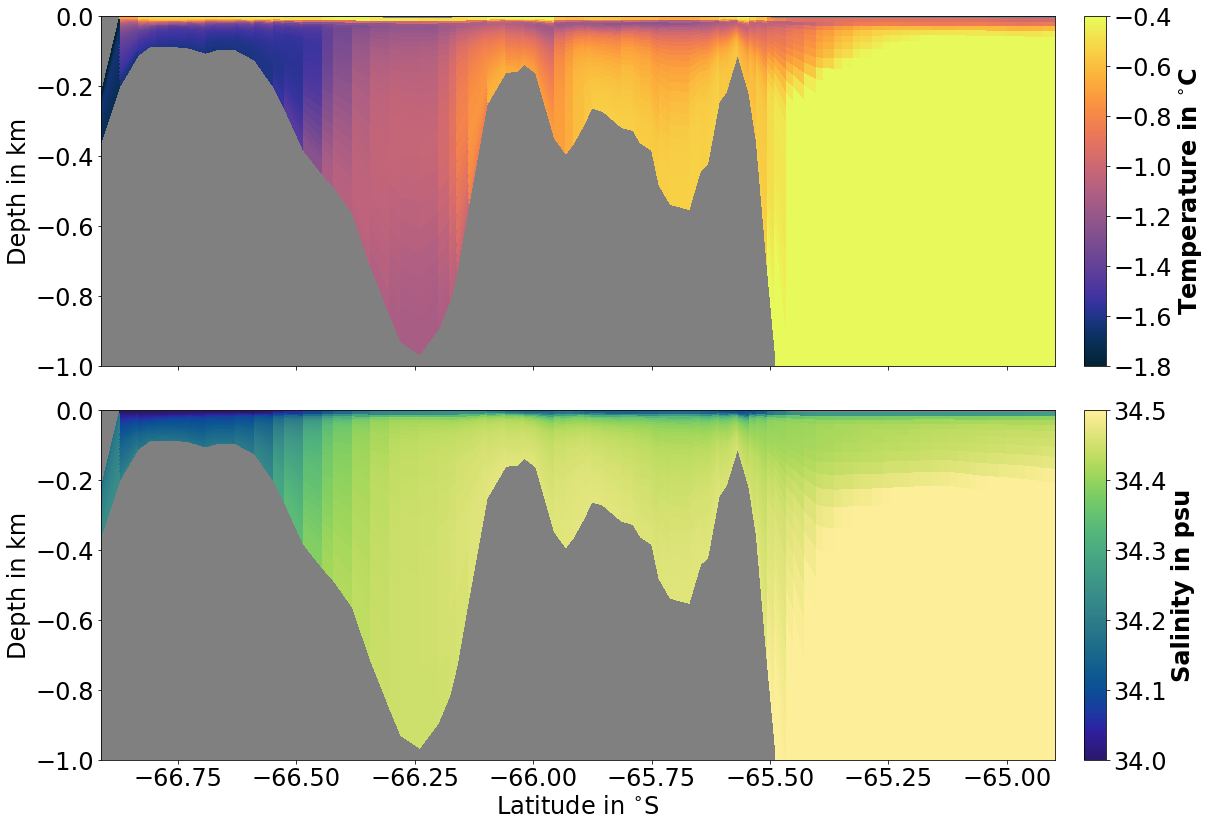

In [226]:
%matplotlib inline
plot_lont('Sabrina coast longitude 120 deg E',rds,sds,120,np.arange(-66.9,-64.5),tmin=-1.8,tmax=-0.4,smin=34.0,
          smax=34.5,
          max_depth=1,size=100,save=True,
         sel={'eta_rho':slice(500,1000),'xi_rho':slice(2500,2750)})

In [35]:
#%%writefile -a ../../src/visualization/compare_tracer.py



### define the plotting function
def compare_onshore(rds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    lons = rds_tr.lon_rho.to_masked_array().squeeze()
    lons[lons<0]+=360.0
    lats = rds_tr.lat_rho.to_masked_array().squeeze()
    
    lon_da = xr.DataArray(lons,dims='latitude')
    lat_da = xr.DataArray(lats,dims='latitude')
    
    print('calculate mean')
    temp_val = rds_tr.temp.to_masked_array().squeeze()
    salt_val = rds_tr.salt.to_masked_array().squeeze()
    
    print('plot')
    plt.close()
    
    fig,axes = plt.subplots(2)
    ax1,ax2 = axes.flatten()
    
    temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    plt.colorbar(temp_plt,ax=ax1,label='Temperature in $^{\circ}$C')
    #ax1.set_title('ROMS')
    #ax0.set_xlabel('latitude')
    #ax1.set_ylabel('depth')

    #sds.temperature.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax2,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    #ax2.set_title('SOSE')

    salt_plt = ax2.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
    plt.colorbar(salt_plt,ax=ax2,label='Salinity in PSU')
    #ax3.set_title('ROMS')
    #ax3.set_xlabel('latitude')
    #ax3.set_ylabel('depth')

    #sds.salinity.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax4,vmin=smin,vmax=smax,cmap=ocm.haline)
    #ax4.set_title('SOSE')

    if max_depth != None:
        for ax in [ax1,ax2]:
            ax.set_ylim([-max_depth,0])
    
    plt.show()        

### Davis sea

define slice
calculate mean
plot


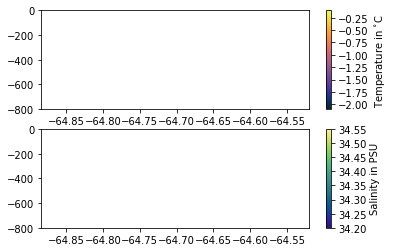

In [36]:
compare_onshore(rds,davis,tmin=-2.1,tmax=-0.1,smin=34.2,smax=34.55,max_depth=800)

### Weddell Sea

define slice
calculate mean
plot


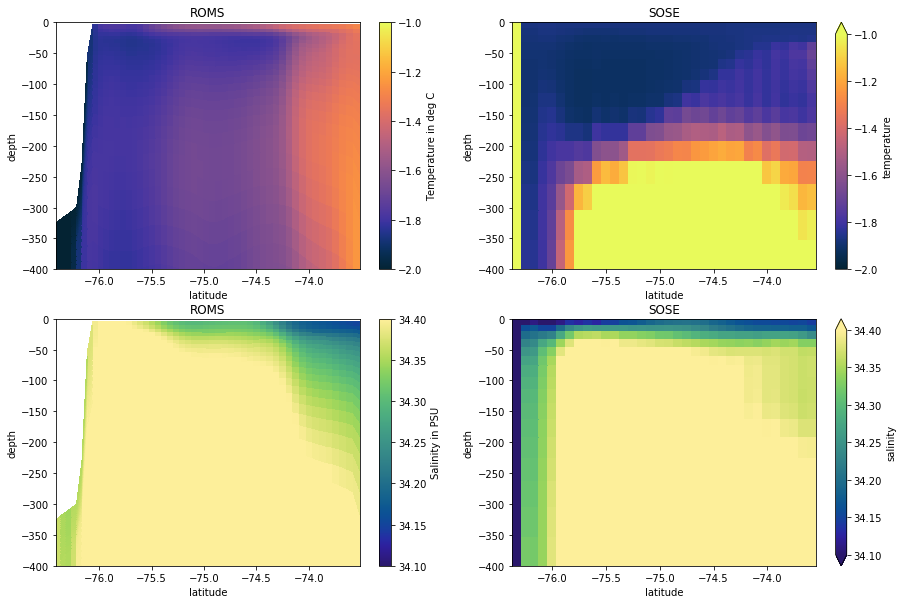

In [46]:
compare_onshore(rds,sds,weddell,tmin=-2.0,tmax=-1.0,smin=34.1,smax=34.4,max_depth=400)

### Amundsen sea

define slice
calculate mean
plot


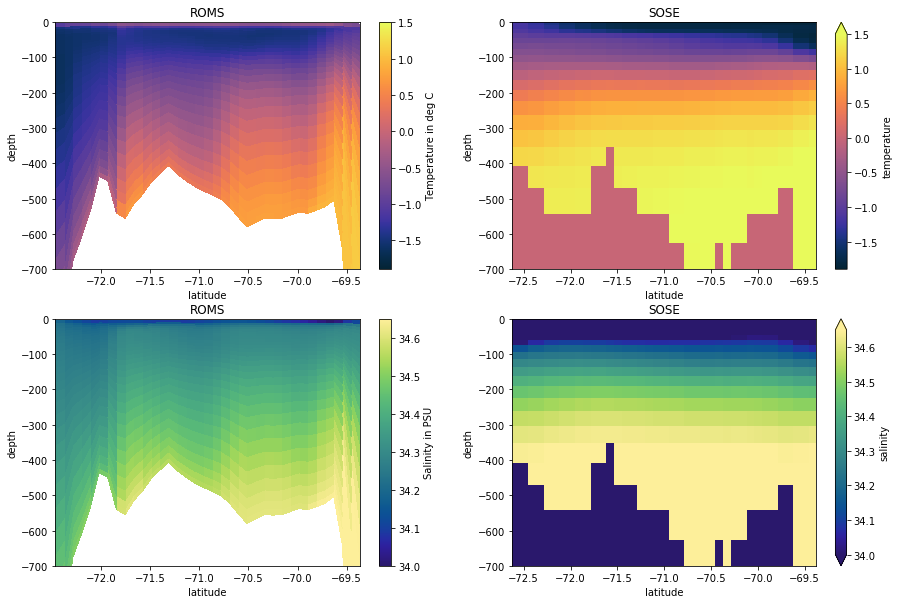

In [50]:
compare_onshore(rds,sds,amundsen,tmin=-1.9,tmax=1.5,smin=34.0,smax=34.65,max_depth=700)

### Ross sea

define slice
calculate mean
plot


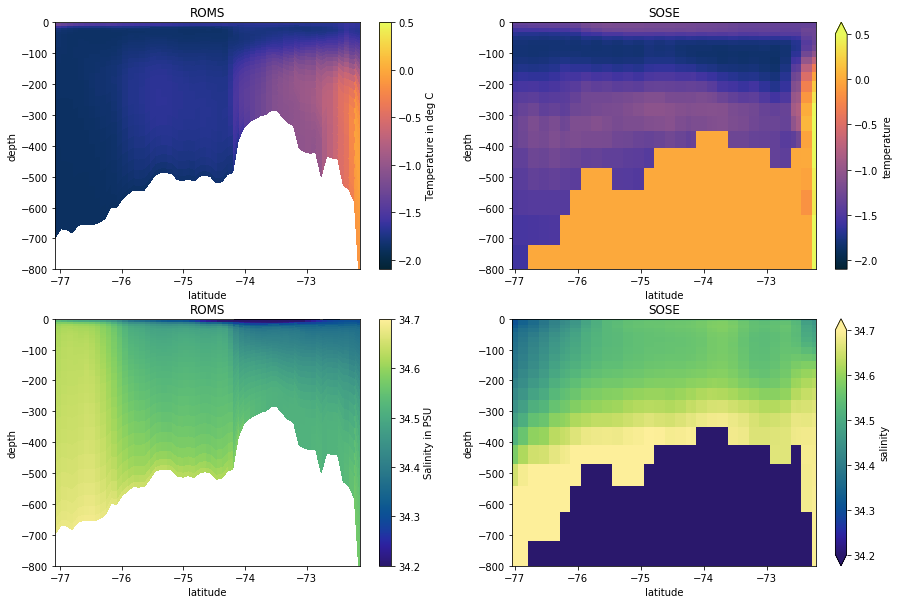

In [48]:
compare_onshore(rds,sds,ross,tmin=-2.1,tmax=0.5,smin=34.2,smax=34.7,max_depth=800)

# Under Ice shelf frontal zone
### Monthly averages ROMS only

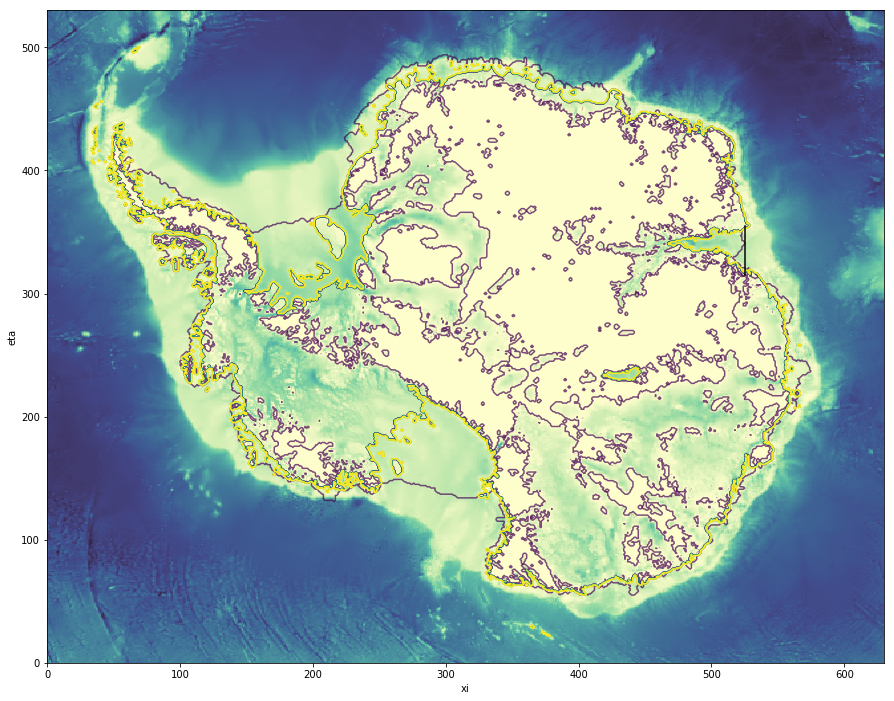

In [73]:
### defining the transsects and plotting them on top of bathy and ice front
plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=ocm.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
#amery=[650,447,660,447,"amery"]
amery=[525,315,525,355,"amery"]
#ross=[450,225,450,240,"ross"]
#weddell=[320,455,320,470,"weddel"]
#bellinghausen=[215,433,225,433,"bellinghausen"]

for line in [amery]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

#plt.xlim((100,750))
#plt.ylim((100,650))
plt.show()

In [54]:
#%%writefile -a ../../src/visualization/compare_tracer.py


### define the plotting routine
def plot_cavity(rds,grd,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    plt.close()

    grd_tr = grd.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))
    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))
    
    x = grd_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    y[np.isnan(y)]=0.0
    
    if mean == True:
        
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))
        
        print('calculate mean')
        temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
        salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()

        print('plot')
        temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
        plt.colorbar(temp_plt,ax=ax1,label='deg C')
        ax1.set_title('Temperature')
        ax1.set_ylabel('depth')

        salt_plt = ax2.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
        plt.colorbar(salt_plt,ax=ax2,label='PSU')
        ax2.set_title('Salinity')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        if max_depth != None:
            for ax in [ax1,ax2]:
                ax.set_ylim([-max_depth,0])
        
        plt.show()
        
    elif mean == False:
        
        print('set up widget')
        def widget(month):
            
            fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))

            temp_val = rds_tr.temp.to_masked_array().squeeze()
            salt_val = rds_tr.salt.to_masked_array().squeeze()

            temp_plt = ax1.pcolormesh(x,y,temp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax1,label='deg C')
            ax1.set_title('Temperature')
            ax1.set_ylabel('depth')

            salt_plt = ax2.pcolormesh(x,y,salt_val[month],vmin=smin,vmax=smax,cmap =ocm.haline)
            plt.colorbar(salt_plt,ax=ax2,label='PSU')
            ax2.set_title('Salinity')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')
            
            if max_depth != None:
                for ax in [ax1,ax2]:
                    ax.set_ylim([-max_depth,0])
            
            plt.show()
            
        interact(widget,month=(0,11))

### Amery ice shelf

In [74]:
plot_cavity(rds,grd,amery,tmin=-1.95,tmax=-1,smin=34.2,smax=34.5,mean=False,max_depth=800)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Ronne Flichner ice shelf

In [ ]:
plot_cavity(rds,weddell,tmin=-2.0,tmax=-1.5,smin=34.2,smax=34.35,mean=False,max_depth=400)

### Ross ice shelf

In [ ]:
plot_cavity(rds,ross,tmin=-1.90,tmax=-1.6,smin=34.25,smax=34.45,mean=False,max_depth=900)

### Wilkins ice shelf

In [ ]:
plot_cavity(rds,bellinghausen,tmin=-1.95,tmax=-0.6,smin=33.6,smax=34.3,mean=False,max_depth=250)